In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import os
import scipy.sparse as sparse
import pickle

from itertools import chain
from pathlib import *
from math import ceil
from sqlalchemy import create_engine

from helper import *
from tree_weight import *
from time import time
from main import make_graph_from_tree
from multiprocessing import *

from typing import List
%matplotlib inline

In [2]:
image_folder = 'graphs/'
tree = 'benchmark_models/grid-colouring/trees/5_6.sqlite'
info_df = to_df(tree, 'info').set_index('NodeID')
nodes_df = to_df(tree, 'nodes').set_index('NodeID')
map_dict = {}

# if 'SubtreeSize' not in nodes_df:
#     calculate_subtree_size(nodes_df)
#     to_sqlite(nodes_df, tree)

# valid_df = nodes_df[nodes_df['Status'] != 3]

# def get_split_var(row, mappings=None):
#     node_idx = row.name
#     par_idx = valid_df.loc[node_idx, 'ParentID']
#     if par_idx == - 1:
#         return None
#     cands, _, par_domain, children_domain = find_split_variable(par_idx, valid_df, info_df, mappings)
#     return cands[0] if len(cands) == 1 else None

# def get_parent_column(column: str, df: pd.DataFrame) -> pd.Series:
#     has_root = 1 if 0 == df.index[0] else 0
#     j = df.iloc[has_root:, :].reset_index().set_index('ParentID')[['NodeID', column]]
#     j.loc[:, column] = df.loc[df.iloc[has_root:, :]['ParentID'], column]    
#     return j.reset_index().set_index('NodeID')[column]
    
# valid_df.loc[:, 'SplitVariable'] = valid_df.apply(get_split_var, axis=1, mappings=map_dict)
# valid_df.loc[:, 'SubtreeSizeWeight'] = valid_df['SubtreeSize'] / get_parent_column('SubtreeSize', valid_df)
# valid_df.loc[:, 'SearchSpaceWeight'] = valid_df['SearchSpaceNodeWeight'] / get_parent_column('SearchSpaceNodeWeight', valid_df)

In [5]:
nodes_df

,ParentID,Alternative,NKids,Status,Label,DFSOrdering,DomainNodeWeight,SearchSpaceNodeWeight,SubtreeSize,SubtreeSizeNodeWeight,UniformNodeWeight
NodeID,,,,,,,,,,,
0,-1,-1,2,2,None,0,1.000000e+00,1.000000,131305,0,1.000000
1,0,0,2,2,X_INTRODUCED_167_[1] = 1,1,1.000000e+00,0.500000,103185,0,0.500000
2,0,1,2,2,X_INTRODUCED_167_[1] != 1,103186,5.764608e-13,0.500000,28119,0,0.500000
3,1,0,2,2,X_INTRODUCED_167_[2] = 1,2,1.000000e+00,0.250000,86161,0,0.250000
4,1,1,2,2,X_INTRODUCED_167_[2] != 1,86163,1.441152e-12,0.250000,17023,0,0.250000
...,...,...,...,...,...,...,...,...,...,...,...
131302,131299,1,0,1,X_INTRODUCED_167_[16] != 1,131293,1.759219e-17,0.000015,1,0,0.000015
131303,131292,0,2,2,X_INTRODUCED_167_[14] = 1,131296,7.036874e-17,0.000061,3,0,0.000061
131304,131292,1,0,1,X_INTRODUCED_167_[14] != 1,131299,7.036874e-17,0.000061,1,0,0.000061


In [96]:
# %%timeit
# post_ordering_no_func = make_post_ordering(nodes_df)
# nodes_df['PostOrdering'] = -1
# nodes_df.loc[post_ordering_no_func, 'PostOrdering'] = range(len(post_ordering_no_func))
# nodes_df.loc[:, 'PostOrdering'] = nodes_df['PostOrdering'].astype(int)

# precompute fitted chracteristic at every parent node
# and perform exponential decay along fitted
fitted_w = nodes_df[nodes_df['Status'] == 2].reset_index()['NodeID'].apply(fit_characteristic, nodes_df=nodes_df)
nodes_df.loc[fitted_w.index, 'fitted_w'] = fitted_w
# fitted_w = fitted_w.ewm(alpha=0.7).mean()
# x = fitted_w.ewm(alpha=0.7).mean()

In [98]:
test = nodes_df.reset_index()[['NodeID', 'DFSOrdering', 'PostOrdering', 'fitted_w']]

In [101]:
test.sort_values('PostOrdering')

,NodeID,DFSOrdering,PostOrdering,fitted_w
13,13,7,0,1.379747
19,19,11,1,11.000000
21,21,13,2,3.000000
23,23,15,3,1.000000
27,27,18,4,21.000000
...,...,...,...,...
39624,39624,41804,45088,NaN
35190,35190,39622,45089,NaN
20184,20184,35188,45090,1.000000
2,2,20182,45091,0.660113


In [37]:
def make_post_ordering_with_func(nodes_df: pd.DataFrame, node_id: int=0, post_ordering: list=None) -> list:
    """
    Return list of node ids in post order, i.e. left subtree - right subtree - root

    We ignored restart nodes.
    """
    if post_ordering is None:
        post_ordering = []

    # base case: current node is a leaf
    if nodes_df.loc[node_id, 'Status'] in {0, 1}:
        return post_ordering

    # else, travel through children
    children = nodes_df[(nodes_df['ParentID'] == node_id) & (nodes_df['Status'] != 3)]\
                .sort_values('Alternative', ascending=True).index
    
    # run recursive algorithm
    for child in children:
        make_post_ordering_with_func(nodes_df, child, post_ordering)
    post_ordering.append((node_id, fit_characteristic(node_id, nodes_df)))


#     if len(post_ordering) == len(nodes_df[nodes_df['Status'] != 3]):
#         assert set(post_ordering) == (set(nodes_df[nodes_df['Status'] != 3].index))
    
    return post_ordering

In [58]:
# %%timeit
# post_ordering_with_func = make_post_ordering_with_func(nodes_df)
fitted_w = pd.DataFrame(post_ordering_with_func, columns=['PostOrdering', 'fitted_w'])
# fitted_w = fitted_w.sort_values('PostOrdering', ascending=True).reset_index(drop=True)['fitted_w']
# y = fitted_w.ewm(alpha=0.7).mean()

In [63]:
nodes_df.shape

(45093, 11)

In [64]:
po.reset_index()

,index,PostOrdering
0,0,28
1,1,25
2,2,32
3,3,26
4,4,24
...,...,...
22541,22541,39624
22542,22542,35190
22543,22543,20184
22544,22544,2


In [102]:
j = pd.DataFrame(post_ordering_with_func, columns=['NodeID', 'fitted_w'])
# j['DFSOrdering'] = nodes_df.loc[j.index, 'DFSOrdering']
j['PostOrdering'] = j.index
j = j.set_index('NodeID')
j['DFSOrdering'] = nodes_df.loc[j.index, 'DFSOrdering']
j.sort_values('PostOrdering')

,fitted_w,PostOrdering,DFSOrdering
NodeID,,,
28,1.000000,0,19
25,3.000000,1,17
32,1.000000,2,24
26,3.000000,3,22
24,1.000000,4,16
...,...,...,...
39624,1.307368,22541,41804
35190,1.508024,22542,39622
20184,1.234153,22543,35188


/home/longdang/WorkStation/University/cpTreeEstimation/main.py:58: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


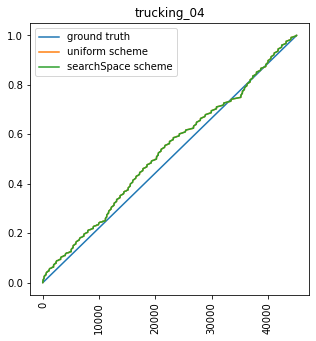

In [2]:
image_folder = 'graphs/'
tree = 'benchmark_models/trucking/trees/04.sqlite'
# info_df = to_df(tree, 'info').set_index('NodeID')
# nodes_df = to_df(tree, 'nodes').set_index('NodeID')
# map_dict = {}

(fig, ax), nodes_df, info_df, cum_sums = \
    make_graph_from_tree(image_folder, tree,
        schemes=[
            'uniform_scheme',
            'searchSpace_scheme',
        ],
    write_to_sqlite=True,
    save_image=True,
    use_parallel=True
    )

In [88]:
assi

In [148]:
%%time
assign_weight(nodes_df, 'searchSpace_scheme', 'NodeWeightTest', use_parallel=True, info_df=info_df)

CPU times: user 829 ms, sys: 60.1 ms, total: 890 ms
Wall time: 47.3 s


Assign weight on trucking 04 with 45100 nodes and search Space scheme:
    - without parallel: 1min 23s ± 1.56 s per loop (mean ± std. dev. of 7 runs, 1 loop each) 
    - with parallel: 54.2 s ± 11.1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

    
Issue:
seemes parallel is not getting everything correct?
Maybe since with parallel the dict used by ws is not stable

In [4]:
# see if subtree sizes follow the same characteristic

def fit_characteristic(node_id, nodes_df=None):
    truth = nodes_df[nodes_df['ParentID'] == node_id]['SubtreeSize'].values
    a_s = [truth[i] / truth[i - 1] for i in range(1, len(truth))]
    return np.mean(a_s) if len(a_s) > 0 else 0

# for each parent node and the corresponding children
weights = nodes_df[nodes_df['Status'] == 2].reset_index()['NodeID'].apply(fit_characteristic, nodes_df=nodes_df)
# weighgs = pd.Series(weights)

# valid_df[valid_df['Status'] == 2].reset_index()['NodeID'].apply(fit_characteristic, nodes_df=valid_df)

nodes_df['
- total time: 20min
- make_dfs_ordering: 3m30s
- load info_df: 365ms
- load nodes_df: 404ms
- copy nodes_df: 7.96ms
- assign weights to nodes_df: 7min30s
- assign weights to test_df: 12min26s
- get_cum_weights for nodes_df: 156ms
- get_cum_weights for test_df: 125ms


f(par_idx) -> list[nkids weights]

Simple solution:
    f(par_idx) = 
    x = np.array([(weight**i) for i in range(nodes_df.loc[par_idx, 'NKids'])])
    # normalize x so it adds to 1
    x = x / x.sum()

ON.RETURN.TO.HIGHER LEVEL
    seen_idx.append(node_id)
    new_weight = fit_characteristic_weight(seen_idx) # find weight that best fit the known curve
    weight = alpha * weight + (1  - alpha) * new_weight # exponential decay
    
    

INITIALIZE WEIGHT
    weight = 1 # no drop of subtree size
    

def fit_characteristic_weight(seen_idx, nodes_df):
    
    truth = nodes_df.loc[seen_idx, 'SubtreeSize'].values
    a_s = [truth[i] / truth[i - 1] for i in range(1, len(truth))]
    return np.mean(a_s)
    
given data subtree_s(0..k):
a1 = subtree_s(1) / subtree_s(0)
a2 = subtree_s(2) / subtree_s(1)
a3 = ...

find w that minimizes 1/2(a1..k - w)^2 -> w = mean(a1, a2, a3, a4)


1, 1/w, 1/w^2, 1/w^3, 1/w^4, ... 1/w^n -> normalized -> 1/w^k * 

sum(1, 1/w, 1/w^2, ... 1/w^n) = S
wS = w + 1 + 1/w + .. + 1/w^(n - 1) = w + S - 1/w^n => S(w - 1) = w - 1/w^n = (w - 1/w^n) / (w - 1)

In [ ]:
nodes_df['No